<a href="https://colab.research.google.com/github/nedokormysh/NLP_Fontanka/blob/main/Pymagic_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install natasha -q
!pip install catboost -q
!pip install optuna -q
!pip install optuna-integration -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 74.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 340.0 kB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS
import datetime

import optuna

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from catboost import CatBoostClassifier
from optuna.integration import CatBoostPruningCallback

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.fasttext import FastText
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, label_binarize
# from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

from sklearn.model_selection import KFold,\
                                    StratifiedKFold, cross_val_score, \
                                    ShuffleSplit, StratifiedShuffleSplit,\
                                    RandomizedSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
    precision_score, recall_score, f1_score, roc_auc_score, log_loss, auc,\
    roc_curve, confusion_matrix, ConfusionMatrixDisplay

import requests

from typing import List, Optional, Tuple, Union

import pickle

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Вспомогательные функции и классы

Собственный класс для выбора колонок. Т.к. для разных моделей захотелось использовать разные колонки, то будем использовать этот класс

In [ ]:
class CustomSelectColumns():
    """
    Класс выбора требуемых колонок
    """
    def __init__(self,
                 selected_feats: List[str] = None):
        """
        :param selected_feats: лист с выбранными признаками
        """
        self.sel_feats = selected_feats
        # print('Init done')
    def fit(self,
            X: pd.DataFrame,
            y: pd.Series = None):
        """
        метод применения класса
        :param X: датасет
        :param y: целевая переменная
        :return: экземпляр класса CustomSelectColumns
        """
        return self

    def transform(self,
                  X: pd.DataFrame,
                  y: pd.Series = None) -> pd.DataFrame:
        """
        метод трансформации датасета
        :param X: датасет
        :param y: целевая переменная
        :return: изменённый датасет
        """
        X_ = X.copy()
        X_filtered = X_[self.sel_feats]
        X_filtered = pd.DataFrame(X_filtered)
        return pd.DataFrame(X_filtered)

Будем трансформировать колонки: масштабировать численные переменные, категориальные кодировать, а текстовые либо создавать токены, либо не изменять.
Собственный класс для трансформации колонок.

In [ ]:
class CustomTransformer():
    """
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки не изменяются.
    После трансформаци возвращается датафрейм.
    """
    def __init__(self,
                 scaler_type: Union[StandardScaler, MinMaxScaler] = None,
                 cat_feats: List[str] = ['month', 'weekday'],
                 txt_feats: List[str] = ['content'],
                 split: bool = False,
                 with_mean: bool = True,
                 with_std: bool = True,
                 feature_range: tuple[int, int]=(0, 1)) -> None:

        """
        :param scaler_type: экземпляр класса мастшабирования или стандартизации
        :param cat_feats: лист с категориальными признаками
        :param txt_feats: лист с текстовыми призаками
        :param split: логическая переменная разбивать строку на токены
        :param with_mean: логическая переменная StandardScaler
                          - вычитать среднее значение
        :param with_std: логическая переменная StandardScaler
                          - делить на стандартное отклоннение
        :param feature_range: параметр класса MinMaxScaler
                          - диапазоном значений, на который масштабируются
                          признаки
        """

        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.split = split

        self.cat_encoder = LabelEncoder()
        self.cat_feats = cat_feats
        self.txt_feats = txt_feats

        # print('Init done')
    def fit(self,
            X: pd.DataFrame,
            y: pd.Series = None):
        """
        метод применения класса
        :param X: датасет
        :param y: целевая переменная
        :return: экземпляр класса CustomSelectColumns
        """
        return self

    def transform(self,
                  X: pd.DataFrame,
                  y: pd.Series=None) -> pd.DataFrame:
        """
        метод трансформации датасета
        :param X: датасет
        :param y: целевая переменная
        :return: изменённый датасет
        """

        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        # категориальные признаки кодируем label_encoder
        for feature in self.cat_feats:
            # X_cat[feature + '_encoded'] = self.cat_encoder.fit_transform(X_cat[feature])
            X_.loc[:, feature + '_encoded'] = self.cat_encoder.fit_transform(X_[feature])
            X_cat = X_cat.drop(columns=[feature])

        num_feats = [i for i in X_.columns if i not in self.cat_feats and i not in self.txt_feats]
        # числовые признаки масштабируем
        X_num = X_[num_feats]

        X_num = pd.DataFrame(self.scaler.fit_transform(X_num), columns=num_feats)
        # текстовые признаки либо разбиваем на токены, либо оставляем так как есть
        if self.split:
            X_txt = X_[self.txt_feats].str.split()
        else:
            X_txt = X_[self.txt_feats]

        X_cat = X_cat.reset_index(drop=True)
        X_num = X_num.reset_index(drop=True)
        X_txt = X_txt.reset_index(drop=True)

        res = pd.concat([X_cat, X_num, X_txt], axis=1)
        return res.reset_index().set_index('index')

In [ ]:
class TfidfEmbeddingVectorizer(object):
    """Класс для получения взвешенных tfidf векторов предложения"""
    def __init__(self,
                 model,
                 column):
        """
        :param model: модель для получения векторных представлений слов
        :param column: колонка, к которой применяем
        """
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size
        self.column = column
        self.max_idf = None

    def tokenize(self, x: List[str]):
        """
        метод для токенизирования, но будем подавать уже токенезированный текст
        :return: лист слов предложения
        """
        return x

    def get_idf(self, tfidf, word):
        """
        метод для получения веса tf_idf
        :param tfidf: модель
        :param word: слово
        :return: число
        """
        index = tfidf.vocabulary_.get(word)
        return tfidf.idf_[index] if index is not None else self.max_idf

    def default_idf(self):
        return self.max_idf

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series):
        """
        метод применения класса
        :param X: датасет
        :param y: целевая переменная
        :return: экземпляр класса CustomSelectColumns
        """
        tfidf = TfidfVectorizer(analyzer=self.tokenize)
        tfidf.fit(X[self.column])
        self.max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            self.default_idf,
            [(w, self.get_idf(tfidf, w)) for w in tfidf.vocabulary_.items()])

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        метод трансформации датасета
        :param X: датасет
        :return: изменённый датасет
        """
        X_tfidf = np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X[self.column]
            ])
        X_tfidf = pd.DataFrame(X_tfidf, columns=[f'tfidf_{i}' for i in range(self.dim)])
        X.drop(self.column, inplace=True, axis=1)
        X = pd.concat([X, X_tfidf], axis=1)

        return X

In [ ]:
def get_metrics_multiclass(y_test_bin: np.array,
                           y_test: np.array,
                           y_pred: np.array,
                           y_prob: np.array,
                           name: str,
                           type_multi: str):
    """

    :param y_test_bin: бинаризованные тестовые метки класса
    :param y_test: метки класса без бинаризации
    :param y_prob: предсказанные вероятности классов
    :param name: - название модели/подхода
    :param type_multi: тип многоклассовой классификации для ROC-AUC (ovo/ovr)
    """

    df_metrics = pd.DataFrame()


    df_metrics['model'] = [name]

    df_metrics['ROC_AUC'] = roc_auc_score(y_test_bin,
                                          y_prob,
                                          multi_class=type_multi)

    df_metrics['Precision_micro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='micro')
    df_metrics['Precision_macro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='macro')

    df_metrics['Recall_micro'] = recall_score(y_test, y_pred, average='micro')
    df_metrics['Recall_macro'] = recall_score(y_test, y_pred, average='macro')

    df_metrics['F1_micro'] = f1_score(y_test, y_pred, average='micro')
    df_metrics['F1_macro'] = f1_score(y_test, y_pred, average='macro')
    df_metrics['F1_weighted'] = f1_score(y_test, y_pred, average='weighted')

    df_metrics['Logloss'] = log_loss(y_test, y_prob)

    return df_metrics

# Преобработка данных

In [ ]:
df = pd.read_csv('/content/prep.csv')
RND_STATE = 7575
sampler = optuna.samplers.TPESampler(seed=RND_STATE)

In [ ]:
# инициализируем листы числовых, категориальных, целевых признаков и признаки,
# которые не потребуются для анализа
cat_features = [#'title',
                #'content',
                'month',
                'weekday']

targets = ['topic',
          #  'views'
           ]
features2drop = ['url', 'views', 'views_by_minutes', 'lifetime', 'datetime',
                 'title', 'title_clean']

filtered_features = [i for i in df.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['month', 'weekday'], amount = 2
num_features: ['content', 'comments_amount', 'year', 'hour', 'log_views', 'len_title', 'len_content', 'log_views_by_minutes', 'content_clean'], amount = 9
targets: ['topic'], amount = 1


In [ ]:
# Заменим тип данных object на category в категориальных признаках

for col in cat_features:
    df[col] = df[col].astype("category")

for col in cat_features:
    df[col] = df[col].astype("category")

In [ ]:
# получаем разбиение на фичи и целевую переменную
X = df[filtered_features].drop(targets, axis=1, errors="ignore")
y = df["topic"]

# разбиение на обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=RND_STATE,
                                                    shuffle=True)

In [ ]:
# кодируем целевую переменную
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

In [ ]:
selected_columns_1 = ['comments_amount',
                      'year',
                      'month',
                      'weekday',
                      'hour',
                      'log_views',
                      'len_title',
                      'len_content',
                      'log_views_by_minutes',
                      # 'title_clean',
                      'content_clean']

# Модели

Загрузим модель, которую уже обучали в Pymagic_baseline

In [ ]:
url = 'https://github.com/nedokormysh/NLP_Fontanka/raw/main/Models/Base/model.pkl'
response = requests.get(url)

with open('model.pkl', 'wb') as f:
    f.write(response.content)

In [ ]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [26]:
n_classes = len(set(y))
y_test_bin = label_binarize(y_test_num, classes=np.arange(0, 10))

# Подбор гиперпараметров

Предобработаем датасет для уменьшения времени работы.

In [ ]:
preprocessor = Pipeline([('selector', CustomSelectColumns(selected_columns_1)),
                         ('preprocessor',
                          CustomTransformer(True,
                                            txt_feats='content_clean',
                                            split=True)),
                         ('tfidf',
                          TfidfEmbeddingVectorizer(model,
                                                   column='content_clean'))])

X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

Привожу код подбора параметров. Вообще изначально делил ноутбук на несколько, чтобы одновременно подбирать параметры для различных моделей.

## One vs Rest

### LogReg

#### RandomSearchCV

In [ ]:
# # создаем препроцессор
# preprocessor = Pipeline([
#     ('selector', CustomSelectColumns(selected_columns_1)),
#     ('preprocessor', CustomTransformer(True, txt_feats='content_clean', split=True)),
#     ('tfidf', TfidfEmbeddingVectorizer(model, column='content_clean'))
# ])

# # создаем классификатор
# clf = LogisticRegression(random_state=RND_STATE, max_iter=10000)
# ovr_clf = OneVsRestClassifier(clf)

# # создаем пайплайн
# pipeline = make_pipeline(preprocessor, ovr_clf)

# # задаем параметры для поиска
# param_dist = {
#     'onevsrestclassifier__estimator__C': [0.01, 0.1, 1, 10, 100],
#     'onevsrestclassifier__estimator__penalty': ['l1', 'l2'],
#     'onevsrestclassifier__estimator__solver': ['liblinear', 'saga'],
#     'onevsrestclassifier__estimator__class_weight': ['balanced', None]
# }

# # создаем и запускаем RandomizedSearchCV
# n_iter_search = 10
# random_search = RandomizedSearchCV(
#     pipeline,
#     param_distributions=param_dist,
#     scoring='f1_weighted',
#     n_iter=n_iter_search,
#     # cv=3,
#     random_state=RND_STATE)
# random_search.fit(X_train, y_train_num)

# # получаем лучшие гиперпараметры
# best_params = random_search.best_params_

In [ ]:
# # создаем пайплайн
# clf = LogisticRegression(random_state=RND_STATE, max_iter=10)
# ovr_clf = OneVsRestClassifier(clf)
# pipeline = make_pipeline(ovr_clf)

# # задаем параметры для поиска
# param_dist = {
#     # 'onevsrestclassifier__estimator__C': [ 0.1, 1, 10, 100],
#     'onevsrestclassifier__estimator__penalty': ['l1',
#                                                 'l2'
#     ],
#     'onevsrestclassifier__estimator__solver': [ 'saga',
#                                               #  'lbfgs'
#     ],
#     # 'onevsrestclassifier__estimator__class_weight': ['balanced', None]
# }

# # создаем и запускаем RandomizedSearchCV
# n_iter_search = 10
# random_search = RandomizedSearchCV(
#     pipeline, param_distributions=param_dist,
#     # n_iter=n_iter_search,
#     cv=2,
#     scoring='f1_weighted',
#     random_state=RND_STATE,
#     verbose=3,
#     n_jobs=-1
#     )
# # random_search.fit(X_train_preprocessed, y_train_num)

# # # получаем лучшие гиперпараметры
# # best_params = random_search.best_params_

In [ ]:
# random_search.fit(X_train_preprocessed, y_train_num)

In [ ]:
# random_search.best_params_

In [ ]:
# # сохраняем модель в файл
# with open('random_search_ovr_lr.pkl', 'wb') as file:
#     pickle.dump(random_search, file)

#### Optuna

In [ ]:
def fit_log_reg_ovr(trial: optuna.trial,
                    train: pd.DataFrame,
                    val: pd.DataFrame,):

    """
    Функция применения алгоритма
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param train: train dataframe
    :type train: pandas.DataFrame
    :param val: validation dataframe
    :type val: pd.DataFrame

    .. notes::
    -----
    Принимает объект trial из optuna, данные для обучения и валидации, алгоритм, параметры.
    Алгоритм обучается и применяется.
    Возвращает обученную модель и предсказанное значение для валидационной выборки

    """
    X_train, y_train = train
    X_val, y_val = val

    param = {"dual": False,
             "C": trial.suggest_float("C", 2.5, 3, step=0.1),
             "solver": trial.suggest_categorical("solver",
                                                 ["sag",
                                                  #"saga",
                                                  "lbfgs"
                                                  ]),
             "random_state": RND_STATE,
             "max_iter": trial.suggest_int("max_iter", 5500, 6300, step=200),
             'multi_class': trial.suggest_categorical("multi_class",
                                                      [#'auto',
                                                       'ovr',
                                                       #'multinomial'
                                                       ]),
             'n_jobs': -1,
             'verbose': 0
    }

    # print(f'param["solver"] = {param["solver"]}')
    if param["solver"] == "saga":
        param["penalty"] = trial.suggest_categorical("penalty",
                                             ['l1',
                                              'l2', #'elasticnet',
                                              None])
    else:
         param["penalty"] = trial.suggest_categorical("penalty",
                                             ['l2',
                                              #None
                                              ])
    print(f'params = {param}')
    clf = LogisticRegression(**param)
    ovr_clf = OneVsRestClassifier(clf)
    ovr_clf.fit(X_train, y_train)

    y_pred = ovr_clf.predict(X_val)
    return ovr_clf, y_pred

In [ ]:
def objective_log_ovr(trial: optuna.trial, return_models:bool=False):
    '''
    Функция рассчёта для поиска параметров при помощи optuna
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param return_models: parameter to return fitted model or not
    :type return_models: bool, defaults to False

    :rtype: float | tuple[float, Any]
    :returns: mean value of f1_weighted metric on folds, model
    .. notes::
    -----
    Принимает объект trial из optuna и булево значение для возможности возврата модели.

    Разбиваем данные на фолды, и подаём в функцию fit algorithm_optuna на каждом разбиении.
    '''
    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RND_STATE)

    scores_simple_acc, scores_f1_weighted, models = [], [], []

    for train_idx, valid_idx in kf.split(X_train.index):
        train_data = X_train_preprocessed.iloc[train_idx], y_train_num[train_idx]
        valid_data = X_train_preprocessed.iloc[valid_idx], y_train_num[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_log_reg_ovr(trial, train_data, valid_data)

        # scores_simple_acc.append(accuracy_score(y_pred, valid_data[1]))
        # scores_balanced_acc.append(balanced_accuracy_score(y_pred, valid_data[1]))
        scores_f1_weighted.append(f1_score(y_pred, valid_data[1], average='weighted'))

        models.append(model)
        break

    result = np.mean(scores_f1_weighted)
    print(f'result = {result}')

    if return_models:
        return result, models
    else:
        return result

In [ ]:
# study = optuna.create_study(direction="maximize",
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
#                             sampler=sampler,
#                             study_name="OVR_Log_Reg_clf")
# study.optimize(objective_log_ovr,
#                n_trials=10,
#                n_jobs=-1,
#                show_progress_bar=True)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 7
Best trial:
  Value: 0.7178719794080773
  Params: 
    C: 2.9
    solver: lbfgs
    max_iter: 5700
    multi_class: ovr
    penalty: l2


In [ ]:
# best_params = study.best_params

In [ ]:
# best_params

{'C': 2.9,
 'solver': 'lbfgs',
 'max_iter': 5700,
 'multi_class': 'ovr',
 'penalty': 'l2'}

In [ ]:
# {'solver': 'lbfgs', 'max_iter': 6100, 'penalty': 'l2'}

In [ ]:
params = {'dual': False,
          'C': 2.9,
          'solver': 'lbfgs',
          'random_state': 7575,
          'max_iter': 5700,
          'multi_class': 'ovr',
          'n_jobs': -1,
          'verbose': 0,
          'penalty': 'l2'}

In [ ]:
preprocessor = Pipeline([
    ('selector', CustomSelectColumns(selected_columns_1)),
    ('preprocessor', CustomTransformer(True, txt_feats='content_clean', split=True)),
    ('tfidf', TfidfEmbeddingVectorizer(model, column='content_clean'))
])


clf = LogisticRegression(**params)
ovr_clf = OneVsRestClassifier(clf)

pipeline_ovr_lr = make_pipeline(preprocessor, ovr_clf)
pipeline_ovr_lr.fit(X_train, y_train_num)
y_pred_num = pipeline_ovr_lr.predict(X_test)
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

               precision    recall  f1-score   support

         авто       0.76      0.11      0.19       150
       бизнес       0.54      0.35      0.43       401
       власть       0.58      0.31      0.40       910
        город       0.73      0.73      0.73      1949
     общество       0.57      0.70      0.63      3315
     политика       0.33      0.02      0.04       235
 происшествия       0.81      0.87      0.84      3769
        спорт       0.92      0.80      0.86       393
строительство       0.85      0.77      0.81       114
      финансы       0.67      0.34      0.45       132

     accuracy                           0.70     11368
    macro avg       0.68      0.50      0.54     11368
 weighted avg       0.69      0.70      0.68     11368



In [ ]:
# сохраняем модель в файл
with open('pipeline_ovr_lr.pkl', 'wb') as file:
    pickle.dump(pipeline_ovr_lr, file)

In [29]:
y_pred_num = pipeline_ovr_lr.predict(X_test)
y_score = pipeline_ovr_lr.decision_function(X_test)

metrics = get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='OVR_LogisticRegresstion_Tuned',
                       type_multi='ovr'
)
metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,OVR_LogisticRegresstion_Tuned,0.941353,0.696517,0.676391,0.696517,0.500157,0.696517,0.536798,0.679938,6.181519


### RandomForest

In [ ]:
def fit_rand_forest_ovr(trial: optuna.trial,
                        train: pd.DataFrame,
                        val: pd.DataFrame,):
    """
    Функция применения алгоритма
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param train: train dataframe
    :type train: pandas.DataFrame
    :param val: validation dataframe
    :type val: pd.DataFrame

    .. notes::
    -----
    Принимает объект trial из optuna, данные для обучения и валидации, алгоритм, параметры.
    Алгоритм обучается и применяется.
    Возвращает обученную модель и предсказанное значение для валидационной выборки

    """
    X_train, y_train = train
    X_val, y_val = val

    param = {"n_estimators": trial.suggest_int("n_estimators", 100, 300, step=50),
             "max_depth": trial.suggest_int("max_depth", 10, 100, step=15),
            #  "min_samples_split": trial.suggest_float("min_samples_split", .1, 1, step=.1),
            #  "min_samples_leaf": trial.suggest_float("min_samples_leaf", .1, .9, step=.1),
             "max_features": trial.suggest_float("max_features", .1, 1, step=.1),
             'class_weight': 'balanced',
             "random_state": RND_STATE,
             'n_jobs': -1,
             'verbose': 0
    }

    # print(f'params = {param}')

    clf = RandomForestClassifier(**param)
    ovr_clf = OneVsRestClassifier(clf)

    ovr_clf.fit(X_train, y_train)

    y_pred = ovr_clf.predict(X_val)
    return ovr_clf, y_pred

In [ ]:
def objective_rand_forest_ovr(trial: optuna.trial, return_models:bool=False):
    '''
    Функция рассчёта для поиска параметров при помощи optuna
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param return_models: parameter to return fitted model or not
    :type return_models: bool, defaults to False

    :rtype: float | tuple[float, Any]
    :returns: mean value of f1_weighted metric on folds, model
    .. notes::
    -----
    Принимает объект trial из optuna и булево значение для возможности возврата модели.

    Разбиваем данные на фолды, и подаём в функцию fit algorithm_optuna на каждом разбиении.
    '''
    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RND_STATE)

    scores_simple_acc, scores_f1_weighted, models = [], [], []

    for train_idx, valid_idx in kf.split(X_train.index):
        train_data = X_train_preprocessed.iloc[train_idx], y_train_num[train_idx]
        valid_data = X_train_preprocessed.iloc[valid_idx], y_train_num[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_rand_forest_ovr(trial, train_data, valid_data)

        # scores_simple_acc.append(accuracy_score(y_pred, valid_data[1]))
        # scores_balanced_acc.append(balanced_accuracy_score(y_pred, valid_data[1]))
        scores_f1_weighted.append(f1_score(y_pred, valid_data[1], average='weighted'))

        models.append(model)
        break

    result = np.mean(scores_f1_weighted)
    # print(f'result = {result}')

    if return_models:
        return result, models
    else:
        return result

In [ ]:
# study = optuna.create_study(direction="maximize",
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
#                             sampler=sampler,
#                             study_name="OVR_Rand_For_clf")
# study.optimize(objective_rand_forest_ovr,
#                n_trials=10,
#                n_jobs=-1,
#                show_progress_bar=True)

In [ ]:
params = {'n_estimators': 100,
          'max_depth': 40, #85,
          'max_features': 0.3,
          'class_weight': 'balanced',
          'random_state': 7575,
          'n_jobs': -1,
          'verbose': 0}

In [ ]:
preprocessor = Pipeline([
    ('selector', CustomSelectColumns(selected_columns_1)),
    ('preprocessor', CustomTransformer(True,
                                       txt_feats='content_clean', split=True)),
    ('tfidf', TfidfEmbeddingVectorizer(model, column='content_clean'))
])


clf = RandomForestClassifier(**params)
ovr_clf = OneVsRestClassifier(clf, verbose=3)

pipeline_ovr_rf = make_pipeline(preprocessor, ovr_clf)
pipeline_ovr_rf.fit(X_train, y_train_num)
y_pred_num = pipeline_ovr_rf.predict(X_test)
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

               precision    recall  f1-score   support

         авто       0.42      0.45      0.44       150
       бизнес       0.34      0.49      0.40       401
       власть       0.53      0.37      0.44       910
        город       0.70      0.65      0.68      1949
     общество       0.58      0.57      0.58      3315
     политика       0.25      0.20      0.22       235
 происшествия       0.79      0.87      0.83      3769
        спорт       0.93      0.67      0.78       393
строительство       0.77      0.72      0.75       114
      финансы       0.36      0.44      0.40       132

     accuracy                           0.66     11368
    macro avg       0.57      0.54      0.55     11368
 weighted avg       0.66      0.66      0.66     11368



In [ ]:
# сохраняем модель в файл
with open('pipeline_ovr_rf.pkl', 'wb') as file:
    pickle.dump(pipeline_ovr_rf, file)

In [30]:
y_pred_num = pipeline_ovr_rf.predict(X_test)
y_score = pipeline_ovr_rf.predict_proba(X_test)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='OVR_RandomForest_Tuned',
                       type_multi='ovr')
])

metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,OVR_LogisticRegresstion_Tuned,0.941353,0.696517,0.676391,0.696517,0.500157,0.696517,0.536798,0.679938,6.181519
0,OVR_RandomForest_Tuned,0.925151,0.659923,0.567086,0.659923,0.543854,0.659923,0.549522,0.656548,1.147723


In [ ]:
# import joblib

# # сохраняем модель в файл
# joblib.dump(pipeline_ovr_rf, 'model_ovr_rf_t.joblib')

## Catboost

In [ ]:
def fit_catboost_simple(trial, train, val):
    """
    Функция применения алгоритма
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param train: train dataframe
    :type train: pandas.DataFrame
    :param val: validation dataframe
    :type val: pd.DataFrame

    .. notes::
    -----
    Принимает объект trial из optuna, данные для обучения и валидации, алгоритм, параметры.
    Алгоритм обучается и применяется.
    Возвращает обученную модель и предсказанное значение для валидационной выборки
    """
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'iterations' : 500,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.04, step=0.001),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 30, 70, step=10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.4, step=0.1),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights",
                                                        ["SqrtBalanced",
                                                         "Balanced",
                                                         "None"]),
        "depth": trial.suggest_int("depth", 9, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", [#"Ordered",
                                                                     "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type",
                                                              [#"Bayesian",
                                                               "Bernoulli",
                                                               #"MVS"
                                                               ]),
        "used_ram_limit": "10gb",
        "eval_metric": "TotalF1",
        'loss_function': 'MultiClass',
        "random_state": RND_STATE,
        'verbose': False
    }


    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)

    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)


    clf = CatBoostClassifier(**param)
    #  Создаем объект callback
    pruning_callback = CatBoostPruningCallback(trial, "TotalF1")

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=5,
        callbacks=[pruning_callback],
    )

    # запускаем процесс прунинга
    pruning_callback.check_pruned()
    y_pred = clf.predict(X_val)

    return clf, y_pred

In [ ]:
def objective_catboost(trial, return_models=False):
    '''
    Функция рассчёта для поиска параметров при помощи optuna
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param return_models: parameter to return fitted model or not
    :type return_models: bool, defaults to False

    :rtype: float | tuple[float, Any]
    :returns: mean value of f1_weighted metric on folds, model
    .. notes::
    -----
    Принимает объект trial из optuna и булево значение для возможности возврата модели.

    Разбиваем данные на фолды, и подаём в функцию fit algorithm_optuna на каждом разбиении.
    '''
    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RND_STATE)

    scores_simple_acc, scores_f1_weighted, models = [], [], []

    for train_idx, valid_idx in kf.split(X_train.index):
        train_data = X_train_preprocessed.iloc[train_idx], y_train_num[train_idx]
        valid_data = X_train_preprocessed.iloc[valid_idx], y_train_num[valid_idx]
        # Подаем trials для перебора
        model, y_pred = fit_catboost_simple(trial, train_data, valid_data) # Определили выше

        # scores_simple_acc.append(accuracy_score(y_pred, valid_data[1]))
        # scores_balanced_acc.append(balanced_accuracy_score(y_pred, valid_data[1]))
        scores_f1_weighted.append(f1_score(y_pred, valid_data[1], average='weighted'))
        models.append(model)
        break

    result = np.mean(scores_f1_weighted)
    # result = scores_balanced_acc
    # print(f'result = {result}')

    if return_models:
        return result, models
    else:
        return result

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.logging.set_verbosity(optuna.logging.ERROR)

In [ ]:
# study = optuna.create_study(direction="maximize",
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
#                             study_name="Catboost_clf_simple",
#                             sampler=sampler)
# study.optimize(objective_catboost,
#                n_trials=40,
#                n_jobs=-1,
#                show_progress_bar=True)

In [ ]:
params = {'learning_rate': 0.039,
 'l2_leaf_reg': 50,
 'colsample_bylevel': 0.4,
 'auto_class_weights': 'None',
 'depth': 9,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.5151799330278385,
 'verbose': 50}

In [ ]:
preprocessor = Pipeline([
    ('selector', CustomSelectColumns(selected_columns_1)),
    ('preprocessor', CustomTransformer(True, txt_feats='content_clean', split=True)),
    ('tfidf', TfidfEmbeddingVectorizer(model, column='content_clean'))
])


clf = CatBoostClassifier(**params)

pipeline_catboost = make_pipeline(preprocessor, clf)
pipeline_catboost.fit(X_train, y_train_num)
y_pred_num = pipeline_catboost.predict(X_test)
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

0:	learn: 2.2039052	total: 3.46s	remaining: 57m 36s
50:	learn: 1.1405474	total: 2m 37s	remaining: 48m 54s
100:	learn: 0.9950061	total: 4m 47s	remaining: 42m 39s
150:	learn: 0.9382543	total: 7m 10s	remaining: 40m 18s
200:	learn: 0.9042412	total: 9m 36s	remaining: 38m 11s
250:	learn: 0.8800825	total: 11m 41s	remaining: 34m 54s
300:	learn: 0.8590725	total: 13m 55s	remaining: 32m 19s
350:	learn: 0.8410965	total: 16m 3s	remaining: 29m 41s
400:	learn: 0.8255621	total: 18m 11s	remaining: 27m 10s
450:	learn: 0.8117966	total: 20m 20s	remaining: 24m 45s
500:	learn: 0.7998348	total: 22m 29s	remaining: 22m 23s
550:	learn: 0.7893289	total: 24m 38s	remaining: 20m 4s
600:	learn: 0.7804033	total: 26m 46s	remaining: 17m 46s
650:	learn: 0.7717612	total: 28m 58s	remaining: 15m 31s
700:	learn: 0.7641109	total: 31m 4s	remaining: 13m 15s
750:	learn: 0.7560398	total: 33m 15s	remaining: 11m 1s
800:	learn: 0.7491330	total: 35m 23s	remaining: 8m 47s
850:	learn: 0.7425900	total: 37m 29s	remaining: 6m 33s
900:	le

In [31]:
y_pred_num = pipeline_catboost.predict(X_test)
y_score = pipeline_catboost.predict_proba(X_test)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='Catboost_simple_Tuned',
                       type_multi='ovr')
])

metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,OVR_LogisticRegresstion_Tuned,0.941353,0.696517,0.676391,0.696517,0.500157,0.696517,0.536798,0.679938,6.181519
0,OVR_RandomForest_Tuned,0.925151,0.659923,0.567086,0.659923,0.543854,0.659923,0.549522,0.656548,1.147723
0,Catboost_simple_Tuned,0.935875,0.679627,0.671470,0.679627,0.471568,0.679627,0.517719,0.666233,0.859879


In [ ]:
# сохраняем модель в файл
with open('pipeline_catboost.pkl', 'wb') as file:
    pickle.dump(pipeline_catboost, file)

# Стекинг

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier,  StackingClassifier

## загрузка log_reg

In [ ]:
# url = 'https://github.com/nedokormysh/NLP_Fontanka/raw/main/Models/Tuned/pipeline_ovr_lr.pkl'
# response = requests.get(url)

# with open('pipeline_ovr_lr.pkl', 'wb') as f:
#     f.write(response.content)

In [ ]:
with open('/content/pipeline_ovr_lr.pkl', 'rb') as f:
    pipeline_ovr_lr = pickle.load(f)

print(type(pipeline_ovr_lr))

<class 'sklearn.pipeline.Pipeline'>


## загрузка random forest

In [ ]:
with open('/content/pipeline_ovr_rf.pkl', 'rb') as f:
    pipeline_ovr_rf = pickle.load(f)

## загрузка catboost

In [ ]:
with open('/content/pipeline_catboost.pkl', 'rb') as f:
    pipeline_catboost = pickle.load(f)

## загрузка catboost txt

In [ ]:
with open('/content/pipe_catboost_txt.pkl', 'rb') as f:
    pipe_catboost_txt = pickle.load(f)

## Stack

In [ ]:
selected_columns_1 = ['comments_amount',
                      'year',
                      'month',
                      'weekday',
                      'hour',
                      'log_views',
                      'len_title',
                      'len_content',
                      'log_views_by_minutes',
                      # 'title_clean',
                      'content_clean']

selected_coumns_2 = ['comments_amount',
       'year',
       'month',
       'weekday',
       'hour',
       'log_views',
       'len_title',
       'len_content',
       'log_views_by_minutes',
       'content'
      #  'title_clean',
      #  'content_clean'
       ]

In [ ]:
# список базовых моделей
estimators = [("CatBoost_simple", pipeline_catboost),
              # ('RF', pipeline_ovr_rf),
              ('OVR_Log_Reg', pipeline_ovr_lr),
              # ("CatBoost_txt", pipe_catboost_txt)
              ]

# в качестве мета-модели будем использовать LogisticRegression
meta_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(verbose=False, max_iter=200, multi_class='multinomial'),
    n_jobs=-1,
    verbose=False,
)

stacking_classifier = meta_model
stacking_classifier

StackingClassifier(estimators=[('CatBoost_simple',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  <__main__.CustomSelectColumns object at 0x795864c7ad10>),
                                                                 ('preprocessor',
                                                                  <__main__.CustomTransformer object at 0x795864c799c0>),
                                                                 ('tfidf',
                                                                  <__main__.TfidfEmbeddingVectorizer object at 0x795864c783d0>)])),
                                                ('catboostclassifier',
                                                 <catboost.core.CatBoostClassi...
                                                                  <__main__.CustomTransformer object at 0x7957f761eda0>),
                                                                 ('tfidf',
                                                                  <__main__.TfidfEmbeddingVectorizer object at 0x7957f761efb0>)])),
                                                ('onevsrestclassifier',
                                                 OneVsRestClassifier(estimator=LogisticRegression(C=2.9,
                                                                                                  max_iter=5700,
                                                                                                  multi_class='ovr',
                                                                                                  n_jobs=-1,
                                                                                                  random_state=7575)))]))],
                   final_estimator=LogisticRegression(max_iter=200,
                                                      verbose=False),
                   n_jobs=-1, verbose=False)

In [ ]:
stacking_classifier.fit(X_train, y_train_num)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('CatBoost_simple',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  <__main__.CustomSelectColumns object at 0x795864c7ad10>),
                                                                 ('preprocessor',
                                                                  <__main__.CustomTransformer object at 0x795864c799c0>),
                                                                 ('tfidf',
                                                                  <__main__.TfidfEmbeddingVectorizer object at 0x795864c783d0>)])),
                                                ('catboostclassifier',
                                                 <catboost.core.CatBoostClassi...
                                                                  <__main__.CustomTransformer object at 0x7957f761eda0>),
                                                                 ('tfidf',
                                                                  <__main__.TfidfEmbeddingVectorizer object at 0x7957f761efb0>)])),
                                                ('onevsrestclassifier',
                                                 OneVsRestClassifier(estimator=LogisticRegression(C=2.9,
                                                                                                  max_iter=5700,
                                                                                                  multi_class='ovr',
                                                                                                  n_jobs=-1,
                                                                                                  random_state=7575)))]))],
                   final_estimator=LogisticRegression(max_iter=200,
                                                      verbose=False),
                   n_jobs=-1, verbose=False)

In [ ]:
# сохраняем модель в файл
with open('stacking_classifier0_2.pkl', 'wb') as file:
    pickle.dump(stacking_classifier, file)

In [24]:
y_pred_num = stacking_classifier.predict(X_test)
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

               precision    recall  f1-score   support

         авто       0.65      0.28      0.39       150
       бизнес       0.53      0.41      0.46       401
       власть       0.56      0.36      0.44       910
        город       0.74      0.72      0.73      1949
     общество       0.59      0.69      0.64      3315
     политика       0.42      0.14      0.21       235
 происшествия       0.82      0.87      0.84      3769
        спорт       0.92      0.80      0.86       393
строительство       0.84      0.80      0.82       114
      финансы       0.59      0.36      0.45       132

     accuracy                           0.70     11368
    macro avg       0.67      0.54      0.58     11368
 weighted avg       0.70      0.70      0.69     11368



In [32]:
y_pred_num = stacking_classifier.predict(X_test)
y_score = pipeline_catboost.predict_proba(X_test)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='Stacking_clf',
                       type_multi='ovr')
])

metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,OVR_LogisticRegresstion_Tuned,0.941353,0.696517,0.676391,0.696517,0.500157,0.696517,0.536798,0.679938,6.181519
0,OVR_RandomForest_Tuned,0.925151,0.659923,0.567086,0.659923,0.543854,0.659923,0.549522,0.656548,1.147723
0,Catboost_simple_Tuned,0.935875,0.679627,0.671470,0.679627,0.471568,0.679627,0.517719,0.666233,0.859879
0,Stacking_clf,0.935875,0.702234,0.665266,0.702234,0.542795,0.702234,0.583015,0.693002,0.859879


# **Выводы:**


In [33]:
metrics = metrics.reset_index(drop=True)
metrics = metrics.set_index("model")
metrics = metrics.sort_values("F1_weighted", ascending=False)

def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: yellow" if v else "" for v in is_max]

styled_metrics = metrics.style.apply(highlight_max, subset=["F1_weighted"])

styled_metrics

,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
model,,,,,,,,,
Stacking_clf,0.935875,0.702234,0.665266,0.702234,0.542795,0.702234,0.583015,0.693002,0.859879
OVR_LogisticRegresstion_Tuned,0.941353,0.696517,0.676391,0.696517,0.500157,0.696517,0.536798,0.679938,6.181519
Catboost_simple_Tuned,0.935875,0.679627,0.671470,0.679627,0.471568,0.679627,0.517719,0.666233,0.859879
OVR_RandomForest_Tuned,0.925151,0.659923,0.567086,0.659923,0.543854,0.659923,0.549522,0.656548,1.147723


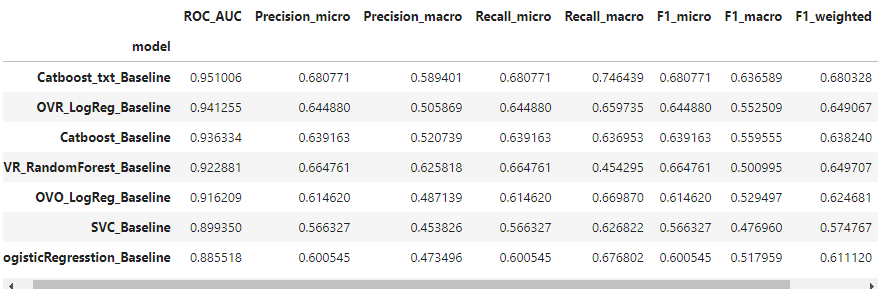

- Произвели подбор гиперпараметров для различных моделей
- Видим улучшения метрик, впрочем всё равно результаты не слишком хорошие.
- Слишком большое сходство между основными тематиками и малое количество объектов в небольших топиках
- Время применения стекинга при заданных параметрах на 2 базовых классификатора и один мета - 5 часов. При этом был получен лучший результат из всех алгоритмов.
- Вероятно улучшения модели можно получить за счёт увеличения количества новостей, использования дополнительных данных со страниц (например, не брал фото), использования векторизирования слов при помощи bert или других современных моделей, дополнительного поиска гиперпараметров для моделей, возможно подбор других моделей.